# IsBit Research and Testing Notebook

## Initial Plan

The initial plan is to split the data set of 5451 question text data into three separate subsets.
The formatting of each data set is described below. The first set contains 80% of the parent data and is reserved for local training of different
clustering models. The remaining 20% are further divided into two unseen test sets of 10% each, one for remote testing exported to the application and another for local evaluation of models(hence containing the coarse-label).

`ML/data/QAQC_v1/swe_local_train.csv`: 

 This is the data source that is preprocessed and split into three subsets.

`ML/data/QAQC_v1/splits/local_train.csv `:

This is the first subset, where data rows are formatted as `Hur utvecklades träldomen i Ryssland?`. These are the questions used for training the local clustering models.

`ML/data/QAQC_v1/splits/local_test.csv`: 

This is the second subset formatted as `Hur utvecklades träldomen i Ryssland?, DESC`. These are questions with additional coarse labels used for local evaluation of the different clustering models.

`ML/data/QAQC_v1/splits/remote_test.csv` :

This is the third subset with the same formatting as the second one. These questions are meant to be used for user-tests exported to the application.

---

## QAQC Preprocessing

The following section will preprocess and split the source data into the three mentioned data slices, keep in mind that all data file names are in the .gitignore to avoid pushing data files to origin, download the source data set to the following path `ML/data/QAQC_v1` and run the preprocessing section to slice the data for training and testing. The souce data can be found at `https://spraakbanken.gu.se/en/resources/sveat` 

If further preprocessing is needed I suggest saving it under `ML/data/QAQC_v2/` and inserting the created file names into .gitignore.

The cells below will filter the source data and create new formatted csv files with the following changes in format compared to the source data,

- Removing commas inside the text field replacing then with pipe signs | .
- Removing outer quotations marks of the textfield.
- Insert escape chars where needed, mostly text fields containing quotes. 

Examples of both raw and processed data files with some normal and edge cases in the data rows can be found under `ML/data_exampels`

In [65]:

# run
# pip install -r ML/requirements.txt

# or run these pip intall 
# > pip install scikit-learn
# > pip install -U sentence-transformers
# > pip install seaborn

# or uncomment lines below and run this cell.
#'%pip install scikit-learn'
#'%pip install sentence-transformers'
#'%pip install seaborn'

Downloads the source data.

In [66]:
import os
import requests

exists = os.path.isfile(os.path.join("./data/QAQC_v1", "swe_qaqc_train.csv"))
if exists:
    print("File exists")
else:
    dataset = "https://svn.spraakbanken.gu.se/sb-arkiv/pub/trec/swe_qaqc_train.csv"
    response = requests.get(dataset)
    open("./data/QAQC_v1/swe_qaqc_train.csv", "wb").write(response.content)
    print("File downloaded")

File exists


Removing of commas and quotations marks.

In [67]:
import pandas as pd
import csv
import re
import os

source_path = "data/QAQC_v1/swe_qaqc_train.csv"        # path to the source data, need to be downloaded ignored for git
output_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"   # set the same output path to not push data to git

# helper to remove outer quotation marks
def strip_outer_quotationmarks(q):
    if q.startswith('"') and q.endswith('"'):
        q = q[1:-1]  
    return q.strip()

# helper to remove commas in the question text, causes problems since the cols are set by commas in csv file
def replace_commas(line):
    pattern = r'"([^"]*?)"'
    def replace_commas(match):
        return '"' + match.group(1).replace(',', '|') + '"'
    return re.sub(pattern, replace_commas, line)

def process_csv(source_data_path, output_data_path, temp_file_path="temp_file.csv"):
    with open(source_data_path, 'r', encoding='utf-8') as infile:
        modified_lines = [replace_commas(line.strip()) for line in infile]

    with open(temp_file_path, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write('\n'.join(modified_lines))

    temp_data = pd.read_csv(temp_file_path, quoting=csv.QUOTE_NONE)  
    questions = temp_data["text"].tolist()
    no_comma_questions = [strip_outer_quotationmarks(q) for q in questions]

    coarse_labels = list(map(lambda x: x.split(":")[0], temp_data["verbose label"].tolist())) # only keep the coarse lable 
    zipped = list(zip(no_comma_questions, coarse_labels))

    with open(output_data_path, 'w', encoding='utf-8', newline='') as outfile:
        writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["text", "coarse label"])
        writer.writerows(zipped)

    if os.path.exists(temp_file_path):
        os.remove(temp_file_path)


    #print(f"Processed data saved to {output_data_path}") # trace print

# data formatted and ready for splitting 
_ = process_csv(source_path, output_path)

QAQC data split Version 1

Splits the formatted data into 80% local training data, 10% local test data and 10% remote user test data.

In [68]:
from sklearn.model_selection import train_test_split

def data_split(source_data_path, split_path):
    
    data = pd.read_csv(source_data_path)
    os.makedirs(split_path, exist_ok=True)
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['coarse label'])
    local_test_data, remote_test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=True, stratify=test_data['coarse label'])
    
    local_train_data = train_data[['text']].copy()  # no need for the lable that wont be used as a lable
    
    local_test_data_for_eval = local_test_data[['text', 'coarse label']].copy()
    remote_test_data_for_eval = remote_test_data[['text', 'coarse label']].copy()
    
    local_train_file = os.path.join(split_path, "local_train.csv")
    local_test_file = os.path.join(split_path, "local_test.csv")
    remote_test_file = os.path.join(split_path, "remote_test.csv")
    
    local_train_data.to_csv(local_train_file, index=False, header=True)
    local_test_data_for_eval.to_csv(local_test_file, index=False, header=True)
    remote_test_data_for_eval.to_csv(remote_test_file, index=False, header=True)
    
    print(f"Data splits saved to: {split_path}")


source_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"
split_path = "data/QAQC_v1/splits/"
data_split(source_path, split_path)


Data splits saved to: data/QAQC_v1/splits/


QAQC data split version 2

Splits the formatted data into 90% training data and 10% for late stage validation.

Creates two copies of the 90% sized set, one without the coarse label and one with the coarse label. The data set **without** the coarse label should be used when creating data points to be sent forward in the application pipe. 

In [69]:
from sklearn.model_selection import train_test_split

import pandas as pd
import os

def data_split(source_data_path, split_path):
    
    data = pd.read_csv(source_data_path)
    os.makedirs(split_path, exist_ok=True)
    
    train_data, test_data = train_test_split(data, test_size=0.1, random_state=42, shuffle=True, stratify=data['coarse label'])
    
    train_data_nl = train_data[['text']].copy()
    train_data_wl = train_data[['text', 'coarse label']].copy()  
    test_data = test_data [['text', 'coarse label']].copy()
    
    train_nl_file = os.path.join(split_path, "train_nl_data.csv")
    train_wl_file = os.path.join(split_path, "train_wl_data.csv")
    test_file  = os.path.join(split_path, "test_data.csv")
    
    train_data_nl.to_csv(train_nl_file, index=False, header=True)
    train_data_wl.to_csv(train_wl_file, index=False, header=True)
    test_data.to_csv(test_file, index=False, header=True)

    print(f"Data splits saved to: {split_path}")


source_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"
split_path = "data/QAQC_v2/splits/"
data_split(source_path, split_path)

Data splits saved to: data/QAQC_v2/splits/


---
# SentenceTransformers

Testing pre trained model referenced on official page of SentenceTransformer

---
# Three different versions of dimensionality reduction

Batches: 100%|██████████| 137/137 [00:16<00:00,  8.45it/s]


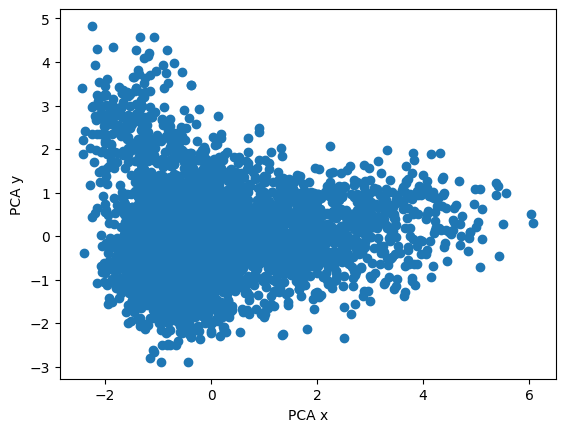

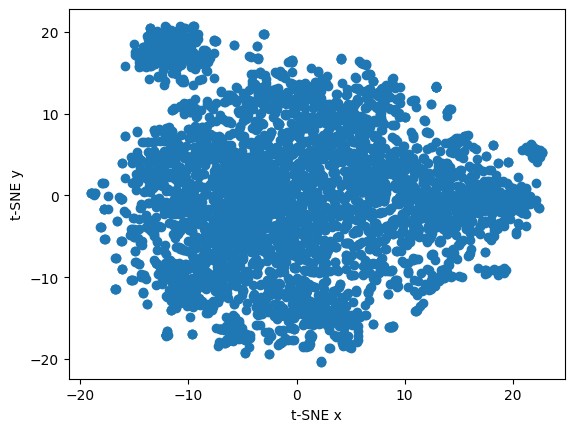

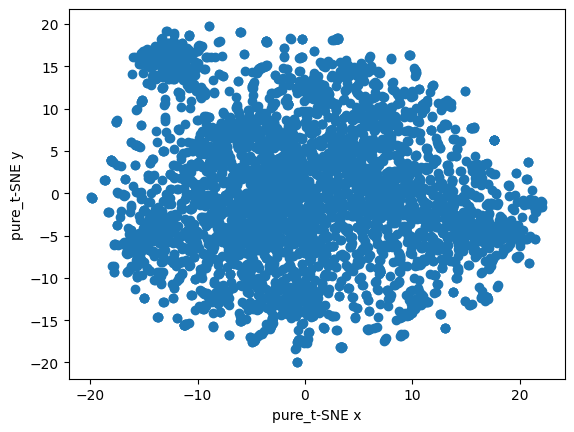

In [70]:
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.manifold import TSNE

local_train_path = "data/QAQC_v1/splits/local_train.csv"
local_train_data = pd.read_csv(local_train_path)
sentences = local_train_data['text'].tolist()

# Step 1: Generate embeddings for the extracted sentences
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True, convert_to_tensor=True)

# Step 2A: Reduce the dimensionality of the embeddings using PCA
pca = PCA(n_components=2, whiten=False, random_state=42)
reduced_embeddings_pca = pca.fit_transform(embeddings)

# Step 2B: Reduce the dimensionality of the embeddings using a combination of PCA and t-SNE(recommended in the scikit learn documentation if initial dimensionality is high)
pca2 = PCA(n_components=50, whiten=False, random_state=42)
reduced_embeddings_pca2 = pca2.fit_transform(embeddings)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, early_exaggeration=4, learning_rate=1000)
reduced_embeddings_tsne = tsne.fit_transform(reduced_embeddings_pca2)

#Step 2C: Reduce the dimensionality of the embeddings using only t-SNE
pure_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, early_exaggeration=4, learning_rate=1000)
reduced_embeddings_tsne2 = pure_tsne.fit_transform(embeddings)


#Step 3: Create dataframes for the different dimensionality reduction techniques
tsne_df = pd.DataFrame(reduced_embeddings_tsne, columns=['x', 'y'])

pca_df = pd.DataFrame(reduced_embeddings_pca, columns=['x', 'y'])

tsne2_df = pd.DataFrame(reduced_embeddings_tsne2, columns=['x', 'y'])

#Step 4: Visualize the embeddings using matplotlib, this is just to show the results here, but the dataframes in step 3 will be sent to backend to be used for generating plots in the frontend.

# Step 4A: Visualize the PCA embeddings using matplotlib
plt.scatter(reduced_embeddings_pca[:, 0], reduced_embeddings_pca[:, 1])
plt.xlabel('PCA x')
plt.ylabel('PCA y')
plt.show()

# Step 4B Visualize the PCA/t-SNE combination embeddings using matplotlib
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1])
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.show()

#Step 4C Visualize the t-SNE embeddings using matplotlib
plt.scatter(reduced_embeddings_tsne2[:, 0], reduced_embeddings_tsne2[:, 1])
plt.xlabel('pure_t-SNE x')
plt.ylabel('pure_t-SNE y')
plt.show()

---
# A cell for manual testing of a potential version of the "first_run" function for the QAQC model

In order for this to work in the model file, the following needs to be done:

* Delete the first two lines in the cell below

* Replace the "data" variable with the data frame(df)

Testing UMAP

---
# Testing for the classification of the data


# Dimensionality Reduction

In [71]:
import torch
from sklearn.ensemble import RandomForestClassifier
import hashlib
import umap
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

def dim_red(embeddings: torch.Tensor, dim: str | None) -> pd.DataFrame:
        """
        Reduces embeddings to 2 dimensions using PCA, TSNE, or UMAP and
        returns a dataframe with the reduced embeddings.
        """
        match dim:
            case "COMBO":
                pca2 = PCA(n_components=50, whiten=False, random_state=42)
                reduced_embeddings_pca2 = pca2.fit_transform(embeddings)
                tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, early_exaggeration=4, learning_rate=1000)
                reduced_embeddings = tsne.fit_transform(reduced_embeddings_pca2)
                point_data_df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])

            case "PCA":
                pca = PCA(n_components=2, random_state=42)
                reduced_embeddings_PCA = pca.fit_transform(embeddings)
                point_data_df = pd.DataFrame(reduced_embeddings_PCA, columns=["x", "y"])

            case "TSNE":
                pure_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, early_exaggeration=4, learning_rate=1000)
                reduced_embeddings_tsne = pure_tsne.fit_transform(embeddings)
                point_data_df = pd.DataFrame(reduced_embeddings_tsne, columns=["x", "y"])

            case "UMAP":
                umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean')
                reduced_embeddings_umap = umap_model.fit_transform(embeddings)
                point_data_df = pd.DataFrame(reduced_embeddings_umap, columns=["x", "y"])

            case _: 
                raise Exception("Invalid dimension reduction method.")
            
        return point_data_df

# Random Forest Classifier

In [72]:
def random_forest_classifier(embeddings: torch.Tensor, user_truth: list):
        max_leaf = 4
        # Initialize the Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=384, random_state=42, max_leaf_nodes=max_leaf)
        #n_estimators should be equal to the embedding space(i.e sentenceswithoutlabels)

        #Generating necessary input for the classifier
        all_old_embeddings_lst = embeddings.tolist()
        if len(user_truth) != len(all_old_embeddings_lst):
            raise Exception("user labeling is not equal to the number of embeddings")
        
        embeddingsWithInputFromUser = []
        embeddingsWithoutInputFromUser = []
        actual_assigned_labels = []
        #Splits the sentences into labeled and unlabeled based on whether they have an input label or not
        for x in range(len(all_old_embeddings_lst)):
              if user_truth[x] == None:
                  embeddingsWithoutInputFromUser.append(all_old_embeddings_lst[x])
              else:
                  embeddingsWithInputFromUser.append(all_old_embeddings_lst[x])
                  actual_assigned_labels.append(user_truth[x])
        
        #Train the classifier        
        clf.fit(embeddingsWithInputFromUser, actual_assigned_labels)

        #Generates new embeddings for use in the frontend
        new_embeddings=clf.apply(all_old_embeddings_lst)

        # Predict the test set results
        label_pred = clf.predict(embeddingsWithoutInputFromUser)

        return (label_pred, new_embeddings)


# Get embeddings

In [73]:
def get_embeddings(text_lst: list) -> torch.Tensor:
        """
        Function to get the embeddings from the sentences
        """
        model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
        embeddings = model.encode(text_lst, convert_to_tensor=True)
        return embeddings

# Latter_run


In [74]:
def latter_run(df: pd.DataFrame, dim: str | None) -> pd.DataFrame:
        questions = df["text"].tolist()
        embeddings_tensor = get_embeddings(questions) #This is equal to the first embeddings(1.2 in our figure)
        user_truth = df["input_label"].tolist()
        #Calls the classifier to generate the predicted labels
        predictedLabels, new_embeddings = random_forest_classifier(embeddings=embeddings_tensor, user_truth=user_truth)
        predLabels_df = pd.DataFrame(predictedLabels.tolist(), columns=["predicted_labels"])
        
        x_and_y = dim_red(embeddings=new_embeddings, dim=dim) #generates coordinates x and y for plotting in frontend

        #Combines all of the dataframes together in order to form the final dataframe
        combined_df = pd.concat([df["text"], x_and_y, df["coarse label"], df["id"] , df["input_label"], predLabels_df], axis=1)
        return combined_df

# Get id

In [75]:

def get_id(content: str) -> str:
        id = hashlib.sha256(bytes(content, 'utf-8')).hexdigest()
        return id

# Method for generating more user labeled data

In [76]:
import random
def get_more_user_input(df: pd.DataFrame):
    """
    Generates more input_label entries for the dataframe
    """
    for i in range(len(df["input_label"])):
                if random.randint(1,100) < 15:
                        if df["input_label"][i] == None:
                                df.loc[i,"input_label"] = df.loc[i,"coarse label"] 
                pass
    return df

# First run

In [77]:

def classifier_input_mock(df: pd.DataFrame, dim: str | None) -> pd.DataFrame:
        """
        Combines the input question data with the calculated 2D point data
        """
        questions = df["text"].tolist()

        ids = [get_id(question) for question in questions]
        df["id"] = pd.Series(ids)
        embeddings = get_embeddings(questions)
        point_data_df = dim_red(embeddings=embeddings, dim=dim)

        user_truth = df["input_label"] = None
        pred_labels = df["predicted_labels"] = None

        #Simulate the generation of the user truth
        df = get_more_user_input(df)
        combined_df = pd.concat([df, point_data_df, user_truth, pred_labels], axis=1)
        return combined_df

# Mocking the dataframe that is supposed to be send from the frontend to the classifier

In [78]:
local_train_path = "data/QAQC_v1/splits/bulle_prep.csv"
local_train_data = pd.read_csv(local_train_path)
input = classifier_input_mock(df = local_train_data, dim ="COMBO")
print(input)


                                                  text coarse label  \
0                Hur utvecklades träldomen i Ryssland?         DESC   
1    Vilka filmer inkluderade karaktären Popeye Doyle?         ENTY   
2    Hur kan jag hitta en lista över kändisars rikt...         DESC   
3    Vilken fjäderfä fångar rampljuset efter det ki...         ENTY   
4              Vad är den fullständiga formen av .com?         ABBR   
..                                                 ...          ...   
994    Hur hittar man kriminella register på Internet?         DESC   
995    Var är skådespelerskan| Marion Davies| begravd?          LOC   
996  Vad är ett exempel på ett faktiskt fall av att...         DESC   
997                     Vem var Charlies parfymkvinna?          HUM   
998  Vem porträtterade Rosanne Rosanna-Dana"" i tv-...          HUM   

                                                    id input_label  \
0    b8a6b34029507c2e67e24621aaed6e2a61173d14a4158d...        None   
1    10

# Testing of latter run

In [79]:
latter_df = latter_run(df=input, dim="COMBO")
print(latter_df)

another_df = get_more_user_input(df=latter_df)
another_df = latter_run(df=latter_df, dim="COMBO")
print(another_df)

                                                  text          x          y  \
0                Hur utvecklades träldomen i Ryssland?   8.546462   2.387668   
1    Vilka filmer inkluderade karaktären Popeye Doyle?   7.826296  -0.980093   
2    Hur kan jag hitta en lista över kändisars rikt...  -8.740296   6.809046   
3    Vilken fjäderfä fångar rampljuset efter det ki...   9.930113   7.149500   
4              Vad är den fullständiga formen av .com?  -3.204157  18.324909   
..                                                 ...        ...        ...   
994    Hur hittar man kriminella register på Internet?   8.329367  -3.141789   
995    Var är skådespelerskan| Marion Davies| begravd?  -1.428121   4.297669   
996  Vad är ett exempel på ett faktiskt fall av att...  -9.656461  11.985502   
997                     Vem var Charlies parfymkvinna?  18.316813  -8.613184   
998  Vem porträtterade Rosanne Rosanna-Dana"" i tv-...   2.875408 -14.138881   

    coarse label                       

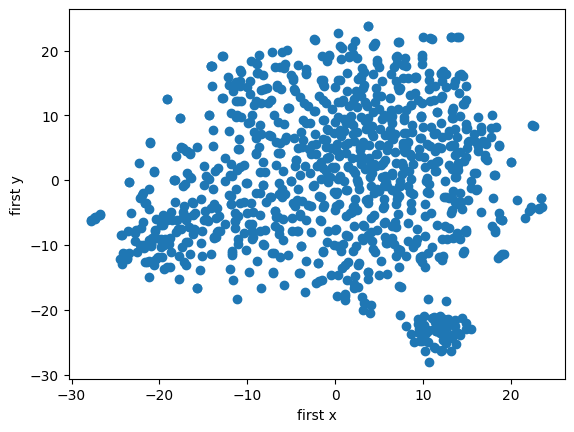

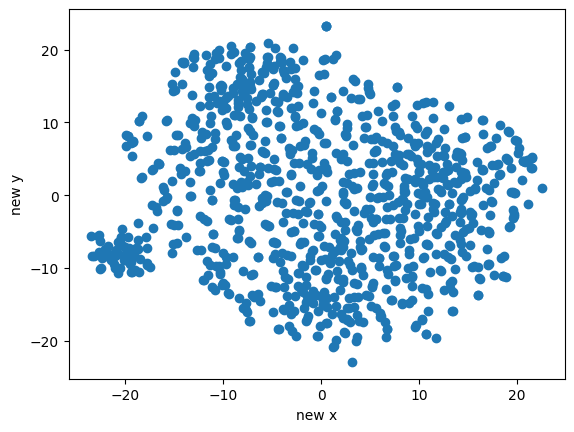

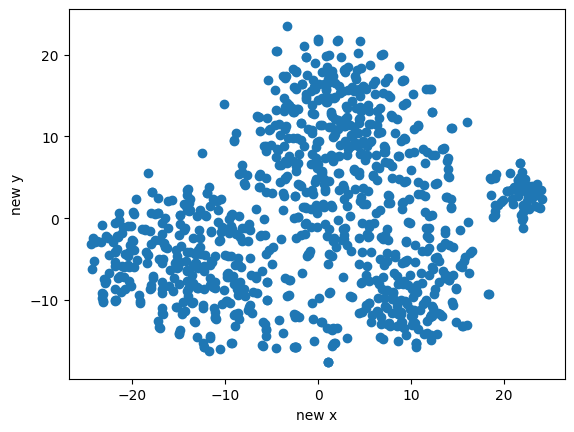

ACCURACY OF THE MODEL latter: 0.16616616616616617
ACCURACY OF THE MODEL another: 0.15615615615615616


In [80]:
from sklearn import metrics
plt.scatter(input["x"], input["y"])
plt.xlabel('first x')
plt.ylabel('first y')
plt.show()

plt.scatter(latter_df["x"], latter_df["y"])
plt.xlabel('new x')
plt.ylabel('new y')
plt.show()

plt.scatter(another_df["x"], another_df["y"])
plt.xlabel('new x')
plt.ylabel('new y')
plt.show()

print("ACCURACY OF THE MODEL latter:", metrics.accuracy_score(latter_df["predicted_labels"].tolist(), latter_df["coarse label"].tolist()))
print("ACCURACY OF THE MODEL another:", metrics.accuracy_score(another_df["predicted_labels"].tolist(), another_df["coarse label"].tolist()))